# Tweet Analysis

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import matplotlib.dates as mdates
import textstat

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***We are going to analyze this dataset from Kaggle. We are trying to uncover patterns that offer insights into how people communicate on Twitter, especially during significant global events, and to build models capable of predicting tweet sentiment.***

In [2]:
# load data
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1') # use encoding='latin-1' to debug UnicodeDecodeError 
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [8]:
# rename columns
df.columns = ['target', 'ids', 'data', 'flag', 'user', 'text'] 
df.head()

,target,ids,data,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
# check target distribution
df['target'].unique()

array([0, 4])

In [14]:
df.head(-10)

,target,ids,data,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599984,4,2193578982,Tue Jun 16 08:38:58 PDT 2009,NO_QUERY,LISKFEST,"if ur the lead singer in a band, beware fallin..."
1599985,4,2193579087,Tue Jun 16 08:38:58 PDT 2009,NO_QUERY,marhgil,@tarayqueen too much ads on my blog.
1599986,4,2193579092,Tue Jun 16 08:38:58 PDT 2009,NO_QUERY,cathriiin,@La_r_a NEVEER I think that you both will get...
1599987,4,2193579191,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,tellman,@Roy_Everitt ha- good job. that's right - we g...


In [5]:
# map target column: 0 (negative), 1 (positive) for readability
df['target'] = df['target'].map({0: 0, 4: 1})

# delete unrelated columns
df = df.drop(columns=['ids', 'flag', 'user'])

# modify data column
# remove the timezone identifier 
df['data'] = df['data'].apply(lambda x: re.sub(r' [A-Z]{3}', '', x))

# change date format
df['data'] = pd.to_datetime(df['data'], errors='coerce')

# set timezone to UTC
df['data'] = df['data'].dt.tz_localize('America/Los_Angeles').dt.tz_convert('UTC')
df.head()

,target,data,text
0,0,2009-04-07 05:19:49+00:00,is upset that he can't update his Facebook by ...
1,0,2009-04-07 05:19:53+00:00,@Kenichan I dived many times for the ball. Man...
2,0,2009-04-07 05:19:57+00:00,my whole body feels itchy and like its on fire
3,0,2009-04-07 05:19:57+00:00,"@nationwideclass no, it's not behaving at all...."
4,0,2009-04-07 05:20:00+00:00,@Kwesidei not the whole crew


In [7]:
# check null value
df.isnull().sum()

target    0
data      0
text      0
dtype: int64

In [6]:
# clean text
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remobe hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces
    return text.lower().strip()          # remove leading/trailing spaces

df['clean_text'] = df['text'].apply(clean_tweet)

In [7]:
# tokenize and remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])
df['clean_text'] = df['clean_text'].apply(remove_stopwords)

## What are the most frequently used words in the entire dataset?

In [11]:
# Create a CountVectorizer to count word frequencies
vectorizer = CountVectorizer(stop_words='english', max_features=10) 
X = vectorizer.fit_transform(df['clean_text'])

# Sum the counts of each word
word_counts = X.sum(axis=0).A1 # convet 2-D matrix to 1-D array
vocab = vectorizer.get_feature_names_out()

# Create a DataFrame for word frequencies
word_freq_df = pd.DataFrame({'word': vocab, 'frequency': word_counts})

# Sort by frequency and display
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
word_freq_df

,word,frequency
5,im,177518
3,good,89397
0,day,82917
6,like,77749
4,got,69684
1,dont,66928
8,today,64609
2,going,64089
7,love,63453
9,work,62763


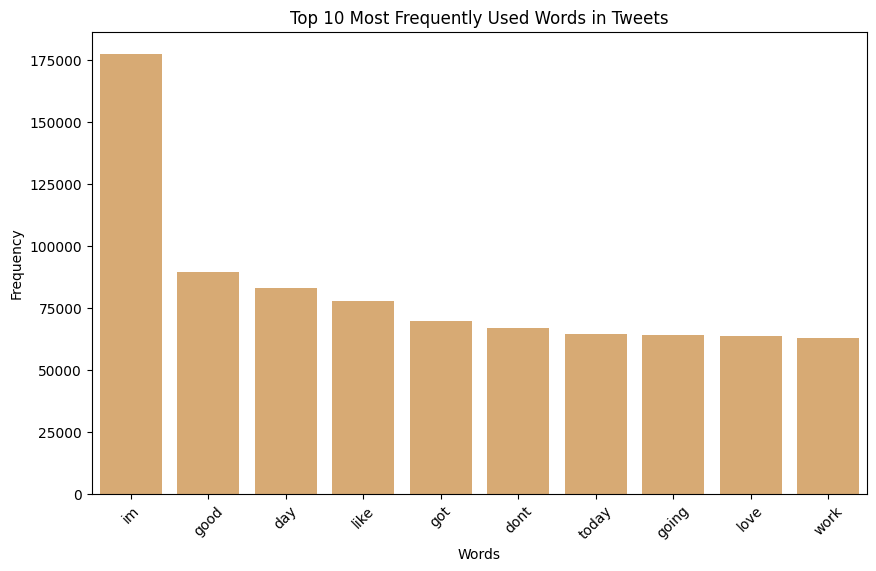

In [12]:
# visulization
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='frequency', data=word_freq_df, color='#E7AB64')

# add title and labels
plt.title('Top 10 Most Frequently Used Words in Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.show()

**These commonly used words suggest that Twitter is primarily used for expressing immediate emotions, discussing daily activities, and providing status updates. Tweets are often short and informal, with users frequently sharing positive sentiments('good', 'love') and information about their day-to-day lives.**

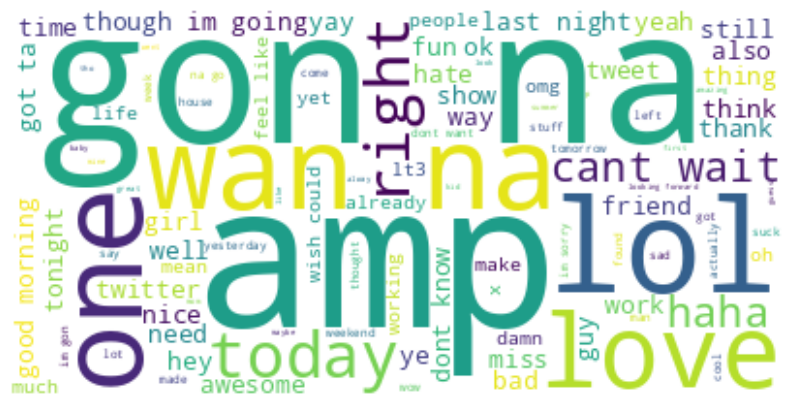

In [8]:
# create word cloud for visulization
# Convert the 'clean_text' to a single string
text = ' '.join(df['clean_text'])

# Create and generate a word cloud image
wordcloud = WordCloud(stopwords='english', background_color='white', max_words=100).generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## How does the distribution of unique words vary across different tweets?

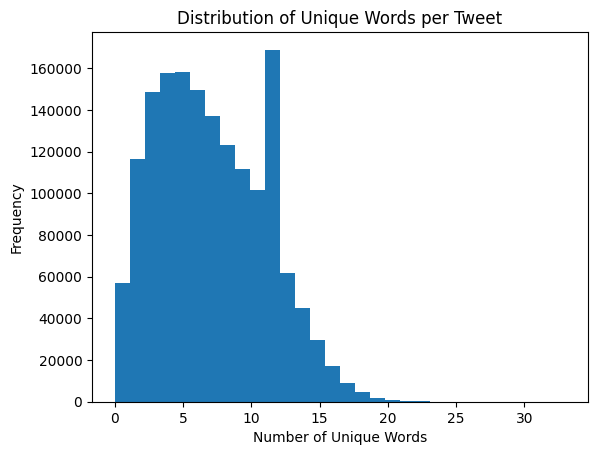

In [14]:
# Calculate number of unique words in each tweet
df['unique_word_count'] = df['clean_text'].apply(lambda x: len(set(x.split())))

# Plot distribution of unique words
df['unique_word_count'].plot(kind='hist', bins=30, title='Distribution of Unique Words per Tweet')
plt.xlabel('Number of Unique Words')
plt.show()

**This chart shows that the vast majority of tweets have a relatively small number of unique words, typically around 12. This reflects Twitter's nature as a platform for short, quick communication. The chart also reveals that while some tweets contain more unique words, these are a minority in the overall dataset. This distribution aligns with Twitter's format, which encourages brevity and concise messaging.**

## What are the most common phrases or n-grams (combinations of two or more words) found in the tweets?

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer for bigrams (2-word combinations)
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10)
X = bigram_vectorizer.fit_transform(df['clean_text'])

# Get bigram frequencies
bigram_counts = X.sum(axis=0).A1
bigrams = bigram_vectorizer.get_feature_names_out()

# Create a DataFrame for bigram frequencies
bigram_freq_df = pd.DataFrame({'bigram': bigrams, 'frequency': bigram_counts})

# Sort and display the most common bigrams
bigram_freq_df = bigram_freq_df.sort_values(by='frequency', ascending=False)
bigram_freq_df

,bigram,frequency
3,gon na,23505
9,wan na,16452
6,im going,10764
4,good morning,9815
5,got ta,8936
0,dont know,8814
2,feel like,6532
7,im gon,6472
8,im sorry,6255
1,dont want,6034


**These high-frequency phrases highlight Twitter users' tendency to use informal, concise language to express emotions, share real-time activities, and engage in daily social interactions, reflecting the platform's role as a fast, real-time communication tool.**

## What are the most common hashtags used in the tweets?

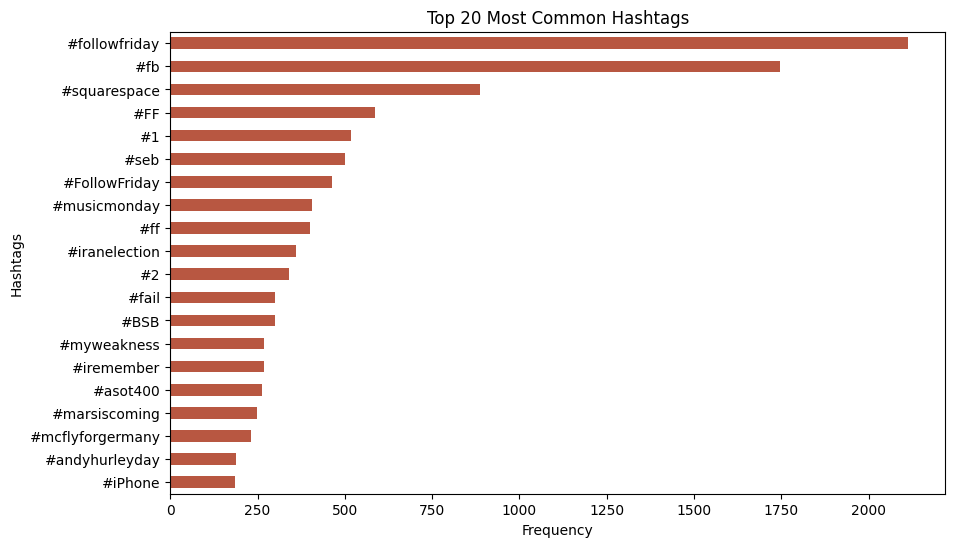

In [9]:
# Function to extract hashtags from the raw tweet text
def extract_hashtags(text):
    # Use regex to find all words starting with '#'
    hashtags = re.findall(r'#\w+', text)
    return hashtags

# Apply the function to create a new column for hashtags
df['hashtags'] = df['text'].apply(extract_hashtags)

# Explode the list of hashtags into separate rows, so each hashtag has its own row
hashtags_series = df['hashtags'].explode()

# Count the occurrences of each unique hashtag
hashtag_counts = hashtags_series.value_counts()

# pick 20 most common hashtags to plot
top_hashtags = hashtag_counts.head(20)

# create horizontal barplot
plt.figure(figsize=(10, 6))
top_hashtags.sort_values().plot(kind='barh', color='#b85741')

# add title and labels
plt.title('Top 20 Most Common Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.show()

**From these hashtags, we can see that Twitter users' primary interests on the platform revolve around social interaction (e.g., #followfriday), pop culture (e.g., #musicmonday), major global events (e.g., #iranelection), brand discussions (e.g., #iPhone), and emotional expression (e.g., #fail).**

## What patterns or trends can be observed from the distribution of tweet activity across different hours of the day? Are there specific times when users tend to be more active?

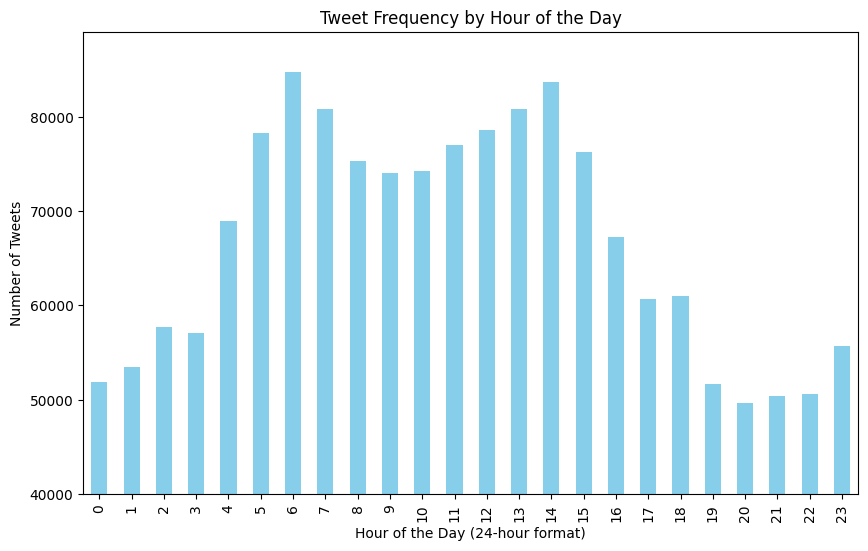

In [40]:
# extract hour from tweet and create a new col
df['hour'] = df['data'].dt.hour

# count number of tweets per hour
tweets_per_hour = df['hour'].value_counts().sort_index()

# create barplot
plt.figure(figsize=(10, 6))
tweets_per_hour.plot(kind='bar', color='skyblue')

# add title and labels
plt.title('Tweet Frequency by Hour of the Day')
plt.xlabel('Hour of the Day (24-hour format)')
plt.ylabel('Number of Tweets')
plt.ylim(40000)
plt.show()

**The tweet posting frequency is highest during the morning to late morning hours, gradually decreases throughout the afternoon, and reaches its lowest point during the night.**

## What is the general sentiment distribution of the tweets in the dataset, and how do positive and negative sentiments compare?

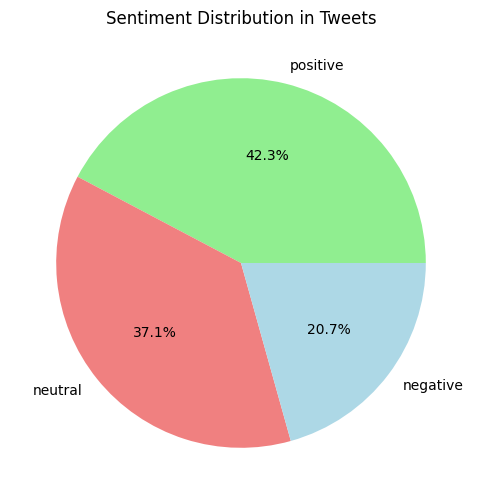

In [8]:
# create a function using TextBlob to do sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# apply function to dataframe and save the result to a new coloumn
df['sentiment'] = df['clean_text'].apply(get_sentiment)

# divide data into positive, negative and neutral based on polarity
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# count number of tweets base on different sentiment
sentiment_counts = df['sentiment_label'].value_counts()

# plot piechart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightblue'])
plt.title('Sentiment Distribution in Tweets')
plt.ylabel('')  # hide y-axis label
plt.show()

**Negative sentiment is present but less common compared to positive and neutral tweets.**

## How did the 2009 Iranian Election(pick one of most common hashtags to further analyze) affect Twitter activity and sentiment trends?

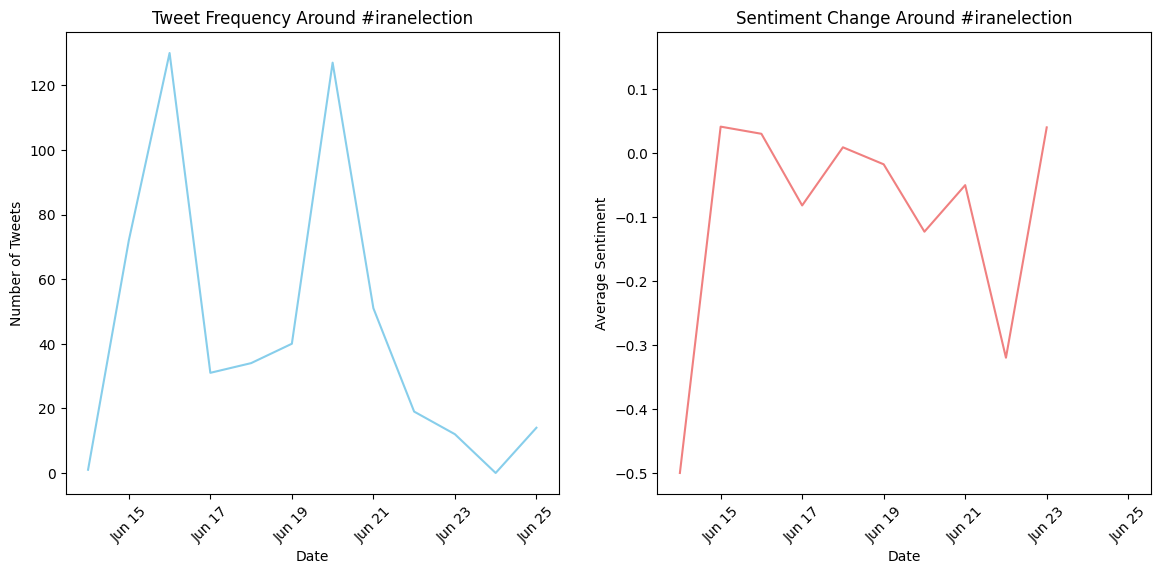

In [17]:
# extract related tweet
event_tweets = df[df['text'].str.contains('#iranelection', case=False)]

# analyze how number of tweet changes before and after event
event_tweets.loc[:, 'date'] = pd.to_datetime(event_tweets['data'], errors='coerce')
tweets_by_day = event_tweets.set_index('date').resample('D').size()

# analyze how sentiment changes before and after event
event_tweets.loc[:, 'sentiment'] = event_tweets['clean_text'].apply(get_sentiment)

# calculate average sentiment daily
sentiment_by_day = event_tweets.set_index('date')['sentiment'].resample('D').mean()

# visualize
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(tweets_by_day, color='skyblue')
ax[0].set_title('Tweet Frequency Around #iranelection')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Tweets')

ax[1].plot(sentiment_by_day, color='lightcoral')
ax[1].set_title('Sentiment Change Around #iranelection')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Average Sentiment')

# modify X-axis label format
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# rotate x-axis labels
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
plt.show()

**The peak in tweet volume on June 15 and June 19 may be linked to critical moments in the event or the release of key news related to it. The sentiment trend suggests that there was initially some positive discussion about the event, but as time went on, the tweets became increasingly negative, which could be attributed to the development of the event and the reactions from the users.**

## How does the readability of tweets vary across different tweet topics?

In [16]:
# calculate Flesch-Kincaid readability (on raw text)
df['readability'] = df['text'].apply(textstat.flesch_kincaid_grade)

df[['text', 'readability']].head()

,text,readability
0,is upset that he can't update his Facebook by ...,3.8
1,@Kenichan I dived many times for the ball. Man...,0.9
2,my whole body feels itchy and like its on fire,0.1
3,"@nationwideclass no, it's not behaving at all....",2.5
4,@Kwesidei not the whole crew,-1.9


In [17]:
# calculate average readability of different sentiments
readability_by_sentiment = df.groupby('target')['readability'].mean()
readability_by_sentiment

target
0    3.657557
1    4.264691
Name: readability, dtype: float64

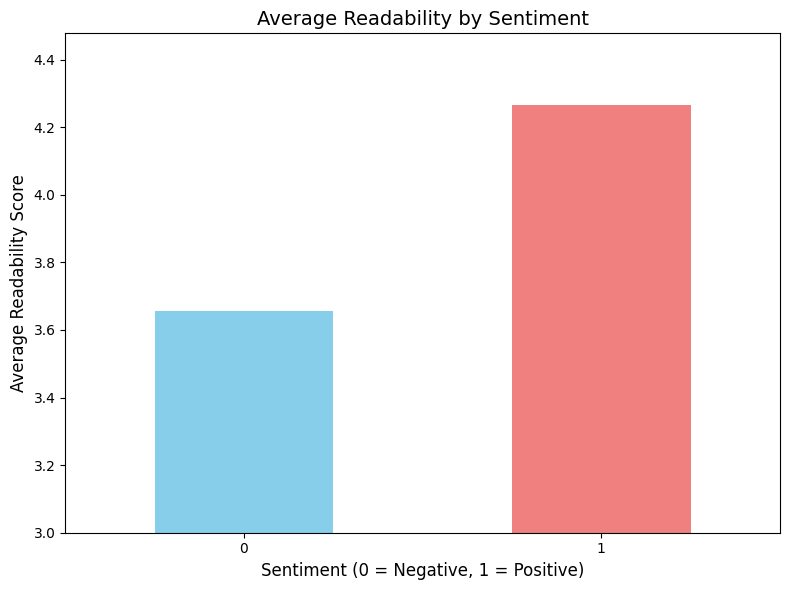

In [19]:
# Create a bar plot
plt.figure(figsize=(8,6))

# Plot the data
readability_by_sentiment.plot(kind='bar', color=['skyblue', 'lightcoral'])

# Add title and labels
plt.title('Average Readability by Sentiment', fontsize=14)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Average Readability Score', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(3.0)
plt.tight_layout()
plt.show()

**In this dataset, tweets with positive sentiment tend to use more complex language and sentence structures compared to those with negative sentiment.**

### Recommendations:

Based on the findings from the analysis of the Twitter dataset, here are several key recommendations:
1. **Targeting Specific Timeframes for Engagement**:
   - From the tweet activity trends, it is evident that users are most active during **morning to late morning hours**. Businesses and social media campaigns should schedule their tweets during these peak hours to maximize engagement and visibility.
2. **Hashtag-Based Campaigns**:
   - Popular hashtags like #followfriday, #musicmonday, and #iranelection indicate that users are interested in both social interaction and global events. Social media strategies should leverage trending hashtags to increase reach and relevance, while focusing on user-generated content to foster greater community interaction.
3. **Event-Based Analysis**:
   - During significant global events like the **2009 Iranian Election**, the dataset shows a spike in tweet activity and shifting sentiments. Monitoring such events can provide valuable insights for real-time sentiment tracking and response strategies, allowing organizations to react to public opinion as events unfold.
     
These recommendations are informed by the insights gathered from the analysis and can be applied to enhance user engagement, sentiment analysis, and content strategy on Twitter.